# 1. Install and Import Dependencies

In [2]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 2. Build Data Loading Functions

In [7]:
import gdown

In [9]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet = False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=adfb95ab-b9a6-4f22-8592-c2aac2f483e5
To: C:\Users\luthr\Desktop\Lip Reading Model\data.zip
100%|███████████████████████| 423M/423M [00:33<00:00, 12.5MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [11]:
def load_video(path:str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [12]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [13]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [17]:
char_to_num = tf.keras.layers.StringLookup(vocabulary = vocab, oov_token = "")
num_to_char = tf.keras.layers.StringLookup(vocabulary = char_to_num.get_vocabulary(), oov_token = "", invert = True)
print(f"The vocabulary is : {char_to_num.get_vocabulary()} "
      f"(size = {char_to_num.vocabulary_size()})")

The vocabulary is : ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size = 40)


In [21]:
char_to_num(['d', 'i', 'c', 'k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 4,  9,  3, 11], dtype=int64)>

In [22]:
num_to_char([4,9,3,11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'd', b'i', b'c', b'k'], dtype=object)>

In [23]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [24]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [28]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [29]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8')

'.\\data\\s1\\bbal6n.mpg'

In [38]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

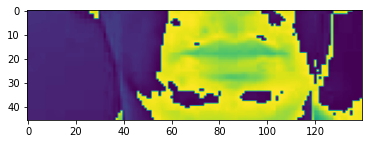

In [39]:
plt.imshow(frames[0])

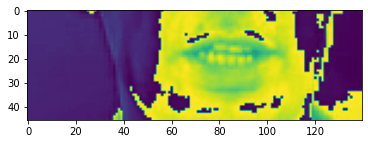

In [40]:
plt.imshow(frames[40])

In [41]:
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'l', ' ', 's', 'i', 'x', ' ', 'n', 'o', 'w']


In [43]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [44]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [42]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 3. Create Data Pipelines

In [45]:
from matplotlib import pyplot as plt

In [47]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration = False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes = ([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)

train = data.take(450)
test = data.skip(450)

In [48]:
len(test)

50

In [49]:
frames, alignments = data.as_numpy_iterator().next()

In [50]:
len(frames)

2

In [51]:
sample = data.as_numpy_iterator()

In [52]:
val = sample.next(); val[0]

array([[[[[1.5416671 ],
          [1.5416671 ],
          [1.5416671 ],
          ...,
          [0.40376994],
          [0.36706358],
          [0.36706358]],

         [[1.5416671 ],
          [1.5416671 ],
          [1.5416671 ],
          ...,
          [0.40376994],
          [0.36706358],
          [0.36706358]],

         [[1.4682543 ],
          [1.4682543 ],
          [1.431548  ],
          ...,
          [0.40376994],
          [0.33035722],
          [0.33035722]],

         ...,

         [[1.027778  ],
          [1.027778  ],
          [1.027778  ],
          ...,
          [0.07341272],
          [0.07341272],
          [0.07341272]],

         [[1.027778  ],
          [1.027778  ],
          [1.027778  ],
          ...,
          [0.07341272],
          [0.07341272],
          [0.07341272]],

         [[1.027778  ],
          [1.027778  ],
          [1.027778  ],
          ...,
          [0.07341272],
          [0.07341272],
          [0.03670636]]],


        [[[1.5049

In [53]:
imageio.mimsave('./animation.gif', val[0][0], fps = 10)

Lossy conversion from float32 to uint8. Range [0.0, 9.360121726989746]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.360121726989746]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.360121726989746]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.360121726989746]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.360121726989746]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.360121726989746]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.360121726989746]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

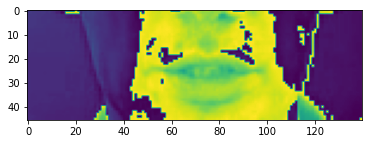

In [54]:
plt.imshow(val[0][0][35])

In [59]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay green at s two now'>

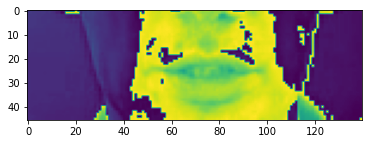

In [60]:
#0:videos, 0:1st video out of the batch, 0:return the first frame in the video
plt.imshow(val[0][0][35])

# 4. Design the Deep Neural Network

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional,MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [66]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [73]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [74]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_1 (Conv3D)           (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation_1 (Activation)   (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 75, 23, 70, 128)   0         
 g3D)                                                            
                                                                 
 conv3d_2 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_2 (Activation)   (None, 75, 23, 70, 256)   0         
                                                      

In [75]:
char_to_num.vocab_size()

40

In [76]:
5*17*75

6375

In [77]:
yhat = model.predict(val[0])

1/1 [==============================] - 16s 16s/step


In [82]:
tf.argmax(yhat[0], axis = 1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([24, 24, 24, 24, 24, 24, 24, 24, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
       27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 27, 27, 27, 27, 27, 27, 27, 27,
       27, 27, 27, 27, 27, 27, 27], dtype=int64)>

In [79]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'xqqqqqqqqqqqqqqqqqqqqqqqqqqqqxxxxxxxxxxxx11111111111111111xqqqqqqqqqqq11111'>

In [84]:
model.input_shape

(None, 75, 46, 140, 1)

In [85]:
model.output_shape

(None, 75, 41)

# 5. Setup Training Options and Train

In [86]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [87]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype = "int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype = "int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype = "int64")
    
    input_length= input_length * tf.ones(shape = (batch_len, 1), dtype = "int64")
    label_length = label_length * tf.ones(shape = (batch_len, 1), dtype = "int64")
    
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [88]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()
        
    def on_epoch_end(self, epoch, logs = None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy = False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original : ', tf.strinigs.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction : ', tf.strinigs.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [103]:
model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.0001), loss = CTCLoss)

In [104]:
checkpoint_callback = ModelCheckpoint(os.path.join('models', 'checkpoint'), monitor = 'loss', save_weights_only = True)

In [105]:
schedule_callback = LearningRateScheduler(scheduler)

In [106]:
example_callback = ProduceExample(test)

In [98]:
model.fit(train, validation_data = test, epochs = 100, callbacks = [checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
  8/450 [..............................] - ETA: 585:39:45 - loss: 70.7662


KeyboardInterrupt



# 6. Make a Prediction

In [100]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet = False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=5531cac6-0f5c-47a7-add7-f59dd45799d4
To: C:\Users\luthr\Desktop\Lip Reading Model\checkpoints.zip
100%|█████████████████████| 94.5M/94.5M [00:07<00:00, 12.7MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [107]:
model.load_weights('models/checkpoint')

In [108]:
test_data = test.as_numpy_iterator()

In [109]:
sample = test_data.next()

In [110]:
yhat = model.predict(sample[0])

1/1 [==============================] - 14s 14s/step


In [113]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set blue by a eight now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin blue with g two please'>]

In [114]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy = True)[0][0].numpy()

In [115]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set blue by a eight now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin blue with g two please'>]

# Test on a video

In [125]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bragzp.mpg'))

In [126]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at g zero please'>]

In [127]:
yhat = model.predict(tf.expand_dims(sample[0], axis = 0))

1/1 [==============================] - 2s 2s/step


In [128]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy = True)[0][0].numpy()

In [129]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at g zero please'>]